In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from concurrent.futures import ProcessPoolExecutor

import desbordante
import numpy as np
import pandas as pd
import seaborn as sns

from sf_permits.config import RAW_DATASET_PATH, PROFILING_DATA_DIR

2024-12-17 10:10:27.678 | INFO     | sf_permits.config:<module>:11 - PROJ_ROOT path is: /home/tomaz/git/Politecnico/Subjects/data-information-quality/sf-permits


In [3]:
df = pd.read_csv(RAW_DATASET_PATH)
df.head()

/tmp/ipykernel_13673/1300652201.py:1: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(RAW_DATASET_PATH)


,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,...,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,...,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,...,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,...,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


In [4]:
df.columns

Index(['Permit Number', 'Permit Type', 'Permit Type Definition',
       'Permit Creation Date', 'Block', 'Lot', 'Street Number',
       'Street Number Suffix', 'Street Name', 'Street Suffix', 'Unit',
       'Unit Suffix', 'Description', 'Current Status', 'Current Status Date',
       'Filed Date', 'Issued Date', 'Completed Date',
       'First Construction Document Date', 'Structural Notification',
       'Number of Existing Stories', 'Number of Proposed Stories',
       'Voluntary Soft-Story Retrofit', 'Fire Only Permit',
       'Permit Expiration Date', 'Estimated Cost', 'Revised Cost',
       'Existing Use', 'Existing Units', 'Proposed Use', 'Proposed Units',
       'Plansets', 'TIDF Compliance', 'Existing Construction Type',
       'Existing Construction Type Description', 'Proposed Construction Type',
       'Proposed Construction Type Description', 'Site Permit',
       'Supervisor District', 'Neighborhoods - Analysis Boundaries', 'Zipcode',
       'Location', 'Record ID'],
     

## Verification

### Correlation-based

In [5]:
with (PROFILING_DATA_DIR / "correlation.json").open() as f:
    correlation_dict = json.load(f)
correlation_df = pd.DataFrame(correlation_dict["table"])
attributes = correlation_df.columns
correlation = correlation_df.to_numpy()
correlation_df

,Permit Type,Street Number,Unit,Number of Existing Stories,Number of Proposed Stories,Estimated Cost,Revised Cost,Existing Units,Proposed Units,Plansets,Existing Construction Type,Proposed Construction Type,Supervisor District,Zipcode,Record ID
Permit Type,1.000000,-0.002281,0.031978,0.057106,0.055431,-0.120878,-0.120083,-0.003030,-0.013665,-0.011480,-0.004265,-0.033203,-0.049109,-0.012200,-0.015621
Street Number,-0.002281,1.000000,-0.040662,-0.218557,-0.215047,-0.011152,-0.010828,-0.054865,-0.055468,-0.003298,0.228214,0.224609,-0.131445,0.107763,-0.039808
Unit,0.031978,-0.040662,1.000000,0.167038,0.168811,-0.009094,-0.007559,0.222569,0.227423,-0.081970,-0.217840,-0.219103,-0.027666,0.003612,-0.275457
Number of Existing Stories,0.057106,-0.218557,0.167038,1.000000,0.997356,0.030248,0.039181,0.295527,0.294521,0.009473,-0.679218,-0.686347,-0.169487,-0.341470,-0.147271
Number of Proposed Stories,0.055431,-0.215047,0.168811,0.997356,1.000000,0.050336,0.049165,0.294658,0.304492,0.009547,-0.688179,-0.683090,-0.168097,-0.342105,-0.147121
Estimated Cost,-0.120878,-0.011152,-0.009094,0.030248,0.050336,1.000000,0.978798,0.014161,0.070412,0.001451,-0.048703,-0.056787,0.009876,-0.010436,0.003439
Revised Cost,-0.120083,-0.010828,-0.007559,0.039181,0.049165,0.978798,1.000000,0.015667,0.065279,0.001309,-0.057447,-0.048473,0.007252,-0.007235,0.004590
Existing Units,-0.003030,-0.054865,0.222569,0.295527,0.294658,0.014161,0.015667,1.000000,0.994071,0.001243,-0.272255,-0.273619,-0.045800,-0.131599,-0.020978
Proposed Units,-0.013665,-0.055468,0.227423,0.294521,0.304492,0.070412,0.065279,0.994071,1.000000,0.001548,-0.275976,-0.289255,-0.040889,-0.137086,-0.018544
Plansets,-0.011480,-0.003298,-0.081970,0.009473,0.009547,0.001451,0.001309,0.001243,0.001548,1.000000,-0.013277,-0.013005,0.001314,-0.005074,-0.001823


<Axes: >

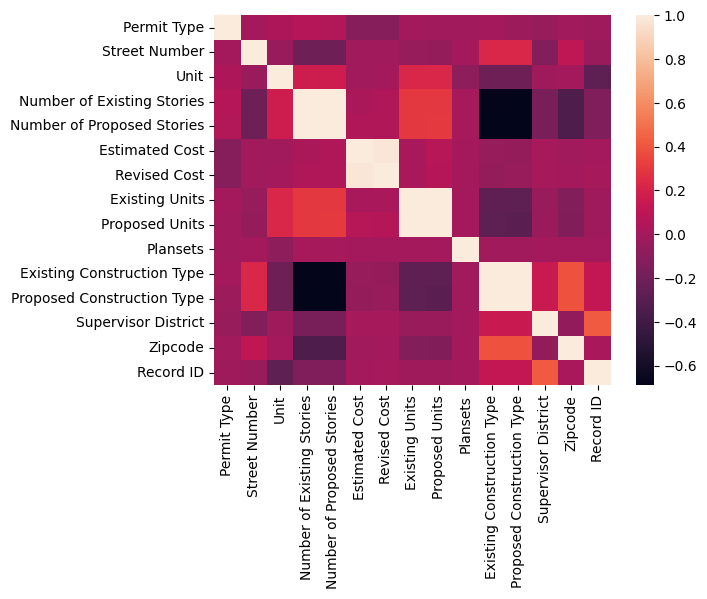

In [6]:
sns.heatmap(correlation_df)

In [7]:
high_correlation_x, high_correlation_y = np.nonzero(np.abs(np.tril(correlation, k=-1)) > 0.6)
print(high_correlation_x, high_correlation_y)

[ 4  6  8 10 10 11 11 11] [ 3  5  7  3  4  3  4 10]


In [8]:
def verify_approximate_function_dependency(args) -> float:
    df, x, y = args
    df = df[~df.iloc[:, [x, y]].isna()]
    fd_verifier = desbordante.afd_verification.algorithms.Default()
    fd_verifier.load_data(table=df)
    fd_verifier.execute(
        lhs_indices=[x],
        rhs_indices=[y],
        afd_error_measure="g1",
    )
    return fd_verifier.get_error()

In [9]:
arguments = [
    (df, x, y)
    for x, y in zip(high_correlation_x, high_correlation_y)
]

In [10]:
with ProcessPoolExecutor() as pool:
    fd_errors = list(pool.map(verify_approximate_function_dependency, arguments))
fd_errors

[0.0005643169721716238,
 0.0008884030772408646,
 8.234703586734162e-05,
 0.7366088436501058,
 0.7367622488799332,
 0.9795998786289868,
 0.9798247343076628,
 0.9031916324807987]

In [11]:
for fd_error, x, y in zip(fd_errors, high_correlation_x, high_correlation_y):
    print(attributes[x].ljust(40), attributes[y].ljust(40), fd_error)

Number of Proposed Stories               Number of Existing Stories               0.0005643169721716238
Revised Cost                             Estimated Cost                           0.0008884030772408646
Proposed Units                           Existing Units                           8.234703586734162e-05
Existing Construction Type               Number of Existing Stories               0.7366088436501058
Existing Construction Type               Number of Proposed Stories               0.7367622488799332
Proposed Construction Type               Number of Existing Stories               0.9795998786289868
Proposed Construction Type               Number of Proposed Stories               0.9798247343076628
Proposed Construction Type               Existing Construction Type               0.9031916324807987


### Manual analysis-based

In [12]:
PRESUMED_DEPENDENCIES = {
    "Neighborhoods - Analysis Boundaries": "Supervisor District",
}

In [23]:
fd_verifier = desbordante.afd_verification.algorithms.Default()
fd_verifier.load_data(table=df)
for lhs_column, rhs_column in PRESUMED_DEPENDENCIES.items():
    lhs_index = df.columns.str.match(lhs_column).argmax()
    rhs_index = df.columns.str.match(rhs_column).argmax()
    fd_verifier.execute(
        lhs_indices=[lhs_index],
        rhs_indices=[rhs_index],
        afd_error_measure="g1",
    )
    print(lhs_column.ljust(40), rhs_column.ljust(40), fd_verifier.get_error())

Neighborhoods - Analysis Boundaries      Supervisor District                      0.011936935100225485


## Discovery

In [3]:
with (PROFILING_DATA_DIR / "duplication.json").open() as f:
    duplication = pd.Series(json.load(f)["attributes"])
duplication

Permit Number                             0.087506
Permit Type                               0.999960
Permit Type Definition                    0.999960
Permit Creation Date                      0.993509
Block                                     0.975385
Lot                                       0.994696
Street Number                             0.974364
Street Number Suffix                      0.991877
Street Name                               0.991433
Street Suffix                             0.999893
Unit                                      0.977611
Unit Suffix                               0.916369
Description                               0.323941
Current Status                            0.999930
Current Status Date                       0.993429
Filed Date                                0.993524
Issued Date                               0.992993
Completed Date                            0.986624
First Construction Document Date          0.992998
Structural Notification        

In [4]:
columns_with_duplicates = duplication[duplication > 0.3].index
columns_with_duplicates

Index(['Permit Type', 'Permit Type Definition', 'Permit Creation Date',
       'Block', 'Lot', 'Street Number', 'Street Number Suffix', 'Street Name',
       'Street Suffix', 'Unit', 'Unit Suffix', 'Description', 'Current Status',
       'Current Status Date', 'Filed Date', 'Issued Date', 'Completed Date',
       'First Construction Document Date', 'Structural Notification',
       'Number of Existing Stories', 'Number of Proposed Stories',
       'Voluntary Soft-Story Retrofit', 'Fire Only Permit',
       'Permit Expiration Date', 'Estimated Cost', 'Revised Cost',
       'Existing Use', 'Existing Units', 'Proposed Use', 'Proposed Units',
       'Plansets', 'Existing Construction Type',
       'Existing Construction Type Description', 'Proposed Construction Type',
       'Proposed Construction Type Description', 'Site Permit',
       'Supervisor District', 'Neighborhoods - Analysis Boundaries', 'Zipcode',
       'Location'],
      dtype='object')

In [5]:
df = pd.read_csv(RAW_DATASET_PATH)[columns_with_duplicates]
df

/tmp/ipykernel_7397/1962240280.py:1: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(RAW_DATASET_PATH)[columns_with_duplicates]


,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,Unit,...,Plansets,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location
0,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,NaN,...,2.0,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)"
1,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,0.0,...,2.0,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)"
2,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,NaN,...,2.0,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)"
3,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,0.0,...,2.0,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)"
4,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,NaN,...,2.0,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198895,8,otc alterations permit,12/05/2017,0113,017A,1228,NaN,Montgomery,St,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198896,8,otc alterations permit,12/05/2017,0271,014,580,NaN,Bush,St,NaN,...,2.0,5.0,wood frame (5),5.0,wood frame (5),NaN,NaN,NaN,NaN,NaN
198897,8,otc alterations permit,12/06/2017,4318,019,1568,NaN,Indiana,St,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198898,8,otc alterations permit,12/06/2017,0298,029,795,NaN,Sutter,St,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df = df.rename(columns={column: column.replace(" ", "_").lower() for column in df.columns})
df

,permit_type,permit_type_definition,permit_creation_date,block,lot,street_number,street_number_suffix,street_name,street_suffix,unit,...,plansets,existing_construction_type,existing_construction_type_description,proposed_construction_type,proposed_construction_type_description,site_permit,supervisor_district,neighborhoods_-_analysis_boundaries,zipcode,location
0,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,NaN,...,2.0,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)"
1,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,0.0,...,2.0,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)"
2,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,NaN,...,2.0,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)"
3,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,0.0,...,2.0,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)"
4,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,NaN,...,2.0,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198895,8,otc alterations permit,12/05/2017,0113,017A,1228,NaN,Montgomery,St,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198896,8,otc alterations permit,12/05/2017,0271,014,580,NaN,Bush,St,NaN,...,2.0,5.0,wood frame (5),5.0,wood frame (5),NaN,NaN,NaN,NaN,NaN
198897,8,otc alterations permit,12/06/2017,4318,019,1568,NaN,Indiana,St,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198898,8,otc alterations permit,12/06/2017,0298,029,795,NaN,Sutter,St,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
afd_miner = desbordante.afd.algorithms.Default()
afd_miner

In [ ]:
afd_miner.load_data(table=df)
afd_miner.execute(error=0.1, afd_error_measure="g1")
afds = afd_miner.get_fds()

In [ ]:
for afd in afds:
    print(afd)

[] -> permit_type
[] -> permit_type_definition
[] -> street_number_suffix
[] -> unit_suffix
[] -> structural_notification
[permit_creation_date] -> filed_date
[supervisor_district] -> lot
[first_construction_document_date] -> issued_date
[issued_date] -> first_construction_document_date
[neighborhoods_-_analysis_boundaries] -> street_number
[location] -> unit
[location] -> number_of_proposed_stories
[location] -> current_status
[location] -> street_name
[location] -> description
[location] -> street_suffix
[location] -> completed_date
[location] -> number_of_existing_stories
[location] -> current_status_date
[description] -> block
[block] -> street_suffix
[current_status_date] -> completed_date
[location] -> lot
[block] -> number_of_proposed_stories
[block] -> street_name
[block] -> unit
[block] -> description
[permit_creation_date] -> street_suffix
[permit_creation_date] -> unit
[block] -> current_status
[permit_creation_date] -> number_of_proposed_stories
[permit_creation_date] -> de